# Fit a cubic function which is monotonically increasing in range [f, g] by a semidefinite programming

find a least squares solution of a cubic polynomial which is monotonically increasing in the range [f, g] and passes through (0, 0) and (1, 1).

such a polynomial has a derivative which can be represented using SOS(sum-of-squares) of polynomials, which in turn can be represented using quadratic forms of symmetric semidefinite matrices.

this notebook shows how to fit such a cubic polynomial to noisy data by first formulate the problem as SDP(semidefinite programming), and then solve the SDP using a convex solver: CVXOPT.

In [1]:
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

## create noisy datapoints from the ground truth

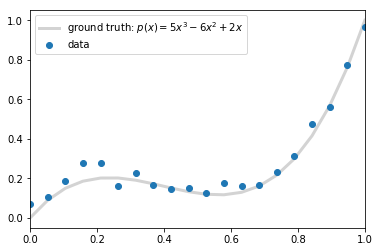

In [2]:
f, g = 0, 1
#gt = [2.2, -1.9, 0.7] # another polynomial. nonnegative derivative in [0, 1]
gt = [2, -6, 5] # ground truth. slightly negative derivative in [0, 1]
def target_func(x): return gt[2] * x**3 + gt[1] * x**2 + gt[0] * x

np.random.seed(0)
xs = np.linspace(f, g, 20)
ts = target_func(xs)
ys = ts + np.random.randn(*xs.shape) * 0.04

fig, ax = plt.subplots(1, 1)
ax.plot(xs, ts, '-', linewidth=3, color='lightgray', label='ground truth: $p(x) = {}x^3 {:+}x^2 {:+}x$'.format(gt[2], gt[1], gt[0]))
ax.plot(xs, ys, 'o', label='data')
ax.set_xlim(f, g)
ax.legend(loc='best', fancybox=True)
plt.show()

## formulate the problem as a SDP and solve it using CVXOPT

In [3]:
# min_param r
#  s.t. param = (s00 s01 s10 s11 | t | r)
#       ||Y - Vp||**2 <= r
#       Y = (y0 y1..), V=(1 x1^1 x1^2 x1^3; ..; 1 xn^1 xn^2 xn^3)
#       p = (p0 p1 p2 p3) = M param
#
#       p(0) = 0, p(1) = 1
#       => p0 = 0, p3 = 1 - p1 - p2

# index for eachvariable.
# - s and t: for nonnegative quadratic function in [0, 1]
# - r: slack variable
i_s00, i_s01, i_s10, i_s11, i_t, i_r = range(6)

# min r = c' param
c = matrix([0.0] * 6)
c[i_r] = 1.0

# define a matrix M to extract polynomial coefficients from <param>.
# (p1 p2 p3) = M param
j_p1, j_p2, j_p3 = range(3)
M = matrix(0.0, (3, 6))
# p1 = s00 - f g t
M[j_p1, i_s00] = 1.0
M[j_p1, i_t] = - f * g
# p2 = (s01 + s10 + (f + g) t) / 2
M[j_p2, i_s01] = 0.5
M[j_p2, i_s10] = 0.5
M[j_p2, i_t  ] = 0.5 * (f + g)
# p3 = s11 - t
M[j_p3, i_s11] = 1.0 / 3
M[j_p3, i_t]   = -1.0 / 3

# V: the Vandermonde's matrix without the head [1] column.
N = len(xs)
V = matrix(0.0, (N, 3))
for i, x in enumerate(xs):
    V[i, j_p1] = x
    V[i, j_p2] = x**2
    V[i, j_p3] = x**3

VM = V * M

# objective least squares is converted into a SDP condition using the slack variable <r>.
#
# s1 = mat(h1) - mat(G1 param) = [ I, V M param; V M param', r + 2 Y' V M param - Y' Y ] >= 0
# dim(V M param) = N.
# => dim(s1) = (N + 1)^2
Y = matrix(ys)
YVM = Y.T * VM
h1 = matrix(0.0, ((N + 1), (N + 1)))
G1 = matrix(0.0, ((N + 1) * (N + 1), 6))
for i in range(N):
    # I block
    h1[i, i] = 1.0
    # V M param block
    for j in range(6):
        G1[i * (N + 1) + N, j] = -VM[i, j]
        G1[N * (N + 1) + i, j] = -VM[i, j]
    # scalar block
    h1[N, N] = - Y.T * Y
    for j in range(6):
        G1[N * (N + 1) + N, j] = - 2 * YVM[j]
    G1[N * (N + 1) + N, i_r] -= 1

# required for nonnegative derivative of the polynomial in range [f, g].
# quadratic that is nonnegative in [f, g] is represented as:
#  f(x) = s(x) + (x-f)(g-x)t(x)
#  where s and t are a SOS(sum-of-squares), which can be constructed from the quadratic form of symmetric semidefinite Qs, Qt.
# s2 = Qs = [s00 s01; s10 s11] >= 0
h2 = matrix(0.0, (2, 2))
G2 = matrix(0.0, (4, 6))
G2[0, i_s00] = -1.0
G2[1, i_s01] = -1.0
G2[2, i_s10] = -1.0
G2[3, i_s11] = -1.0

# s3 = Qt = [t] >= 0
h0 = matrix(0.0, (1, 1))
G0 = matrix(0.0, (1, 6))
G0[i_t] = -1.0

# linear constraints
Ap = matrix(0.0, (1, 3))
b = matrix(0.0, (2, 1))
# p1 + p2 + p3 = 1
Ap[0, j_p1] = 1.0
Ap[0, j_p2] = 1.0
Ap[0, j_p3] = 1.0
b[0] = 1.0
A = matrix(0.0, (2, 6))
A[0, :] = Ap * M
# s01 = s10
A[1, i_s01] = 1.0
A[1, i_s10] = -1.0
b[1] = 0.0

# solve the SDP.
result = solvers.sdp(c, Gs=[G0, G1, G2], hs=[h0, h1, h2], A=A, b=b)
s00, s01, s10, s11, t, r = result['x']
s1 = np.array([s00, s01, s10, s11]).reshape(2, 2)
print(s1)

result

     pcost       dcost       gap    pres   dres   k/t
 0: -3.2674e+00 -2.8135e+01  1e+02  2e+00  2e+01  1e+00
 1:  3.5060e-01 -6.8932e+00  3e+01  8e-01  5e+00  2e+00
 2:  2.5985e-01 -5.5087e-01  2e+00  1e-01  8e-01  5e-01
 3: -9.1482e-02 -8.1955e-01  2e+00  1e-01  7e-01  4e-01
 4: -4.4152e-02 -7.3975e-01  2e+00  9e-02  6e-01  3e-01
 5:  6.7418e-02 -3.3066e-02  3e-01  1e-02  9e-02  5e-02
 6:  9.7861e-02  4.9564e-02  1e-01  6e-03  4e-02  2e-02
 7:  1.0320e-01  1.0051e-01  8e-03  3e-04  2e-03  8e-04
 8:  1.0382e-01  1.0312e-01  2e-03  8e-05  5e-04  1e-04
 9:  1.0391e-01  1.0384e-01  2e-04  8e-06  5e-05  2e-05
10:  1.0393e-01  1.0391e-01  6e-05  2e-06  1e-05  4e-06
11:  1.0394e-01  1.0393e-01  7e-06  3e-07  2e-06  5e-07
12:  1.0394e-01  1.0394e-01  2e-06  8e-08  5e-07  1e-07
13:  1.0394e-01  1.0394e-01  3e-07  1e-08  8e-08  2e-08
14:  1.0394e-01  1.0394e-01  8e-08  3e-09  2e-08  4e-09
Optimal solution found.
[[ 1.34971618 -3.66251449]
 [-3.66251449  9.93839491]]


{'dual infeasibility': 1.987483881110028e-08,
 'dual objective': 0.10393645731633162,
 'dual slack': 3.0069220413513766e-10,
 'gap': 7.800988610693418e-08,
 'iterations': 14,
 'primal infeasibility': 3.1365912695792743e-09,
 'primal objective': 0.10393648779166373,
 'primal slack': 8.294144522888279e-10,
 'relative gap': 7.505536374932458e-07,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 'sl': <0x1 matrix, tc='d'>,
 'ss': [<1x1 matrix, tc='d'>, <21x21 matrix, tc='d'>, <2x2 matrix, tc='d'>],
 'status': 'optimal',
 'x': <6x1 matrix, tc='d'>,
 'y': <2x1 matrix, tc='d'>,
 'zl': <0x1 matrix, tc='d'>,
 'zs': [<1x1 matrix, tc='d'>, <21x21 matrix, tc='d'>, <2x2 matrix, tc='d'>]}

In [4]:
p = M * result['x']
p1 = p[j_p1]
p2 = p[j_p2]
p3 = p[j_p3]

import IPython.display
print('found a polynomial:')
IPython.display.display(IPython.display.Math(r'p(x) = {}x^3 {:+}x^2 {:+}x'.format(p3, p2, p1)))
print('ground truth:')
IPython.display.display(IPython.display.Math(r'p(x) = {}x^3 {:+}x^2 {:+}x'.format(gt[2], gt[1], gt[0])))

found a polynomial:


<IPython.core.display.Math object>

ground truth:


<IPython.core.display.Math object>

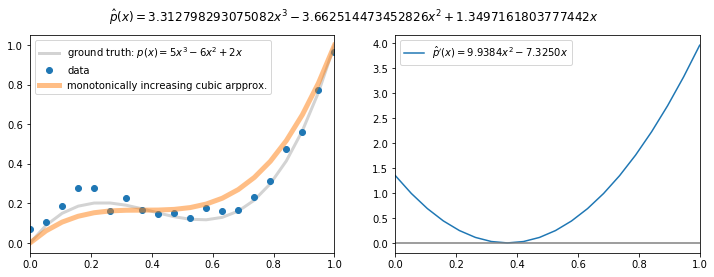

In [5]:
# visualize
def found_cubic_polynomial(x):
    return p3 * x**3 + p2 * x**2 + p1 * x
def found_cubic_polynomial_prime(x):
    return 3 * p3 * x**2 + 2 * p2 * x + p1

fs = found_cubic_polynomial(xs)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(xs, ts, '-', linewidth=3, color='lightgray', label='ground truth: $p(x) = {}x^3 {:+}x^2 {:+}x$'.format(gt[2], gt[1], gt[0]))
ax[0].plot(xs, ys, 'o', label='data')
ax[0].plot(xs, fs, '-', linewidth=5, alpha=0.5, label='monotonically increasing cubic arpprox.')
ax[0].set_xlim(f, g)
ax[0].legend(loc='best', fancybox=True)
ax[1].plot(xs, found_cubic_polynomial_prime(xs), label=r'$\hat{{p}}^\prime(x) = {:.4f}x^2 {:+.4f}x$'.format(3*p3, 2*p2))
ax[1].axhline(y=0, color='gray')
ax[1].set_xlim(f, g)
ax[1].legend(loc='best', fancybox=True)
fig.suptitle(r'$\hat{{p}}(x) = {}x^3 {:+}x^2 {:+}x$'.format(p3, p2, p1))
plt.show()

# Reference
 * CVXOPT semidefinite programming: http://cvxopt.org/userguide/coneprog.html#semidefinite-programming
 * use a quadratic objective in SDP: https://math.stackexchange.com/questions/2256241/writing-a-convex-quadratic-program-qp-as-a-semidefinite-program-sdp
 * sums of squares for nonnegative polynominals: http://stellar.mit.edu/S/course/6/sp10/6.256/courseMaterial/topics/topic2/lectureNotes/lecture-10/lecture-10.pdf
 * monotonically increasing polynomials: https://math.stackexchange.com/questions/60610/polynomial-fitting-where-polynomial-must-be-monotonically-increasing
 